## Import the required packages

In [15]:
import os
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import math
import json
import pandas as pd

## Load EA data

In [111]:
fname = "../data-in/ibadan_EAs_of_interest/shapefile_of_Ibadan_EAs_of_interest.shx"
ib_data = gpd.read_file(fname)
ib_data.head()

,city,ward,ea_code,EAS,Latitude,Longitude,Settlement,geometry
0,Ibadan,Agugu,Ag_001,Opposite Christ the king primary school I,3.919976,7.386031,Slum,POINT (3.91998 7.38603)
1,Ibadan,Agugu,Ag_002,Beside Christ the King Primary School I,3.920514,7.386621,Slum,POINT (3.92051 7.38662)
2,Ibadan,Agugu,Ag_003,Behind Christ the kind Primary School I,3.920634,7.385972,Slum,POINT (3.92063 7.38597)
3,Ibadan,Agugu,Ag_004,Behind The Board of Trade,3.922894,7.386947,Slum,POINT (3.92289 7.38695)
4,Ibadan,Agugu,Ag_005,Opposite The Board of Trade,3.922421,7.386521,Slum,POINT (3.92242 7.38652)


In [112]:
# ib_data.head()

In [113]:
ib_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   city        378 non-null    object  
 1   ward        378 non-null    object  
 2   ea_code     378 non-null    object  
 3   EAS         378 non-null    object  
 4   Latitude    378 non-null    float64 
 5   Longitude   378 non-null    float64 
 6   Settlement  378 non-null    object  
 7   geometry    378 non-null    geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 23.8+ KB


In [114]:
ib_data.ward.unique()

array(['Agugu', 'Bashorun', 'Challenge', 'Olopomewa'], dtype=object)

In [115]:
ib_data.Settlement.value_counts()

Settlement
informal    127
Informal     71
Formal       58
formal       55
Slum         47
slums        13
slum          7
Name: count, dtype: int64

### Preprocess a few features of interest

In [116]:
ib_data_v2 = ib_data.copy()
ib_data_v2["Settlement"] = [item.replace("slums", "slum").lower() if item=="slums" else item.lower() for item in ib_data_v2.Settlement.to_list()]
ib_data_v2.head()

,city,ward,ea_code,EAS,Latitude,Longitude,Settlement,geometry
0,Ibadan,Agugu,Ag_001,Opposite Christ the king primary school I,3.919976,7.386031,slum,POINT (3.91998 7.38603)
1,Ibadan,Agugu,Ag_002,Beside Christ the King Primary School I,3.920514,7.386621,slum,POINT (3.92051 7.38662)
2,Ibadan,Agugu,Ag_003,Behind Christ the kind Primary School I,3.920634,7.385972,slum,POINT (3.92063 7.38597)
3,Ibadan,Agugu,Ag_004,Behind The Board of Trade,3.922894,7.386947,slum,POINT (3.92289 7.38695)
4,Ibadan,Agugu,Ag_005,Opposite The Board of Trade,3.922421,7.386521,slum,POINT (3.92242 7.38652)


In [117]:
ib_data_v2.Settlement.value_counts()

Settlement
informal    198
formal      113
slum         67
Name: count, dtype: int64

In [118]:
ib_data_v2.loc[ib_data['ward'] == "Agugu"].Settlement.value_counts()

Settlement
informal    51
slum        40
Name: count, dtype: int64

In [119]:
ib_data_v2.loc[ib_data_v2['ward'] == "Bashorun"].Settlement.value_counts()

Settlement
formal      58
informal    20
slum         7
Name: count, dtype: int64

In [121]:
ib_data_v2.loc[ib_data_v2['ward'] == "Challenge"].Settlement.value_counts()

Settlement
informal    105
formal       24
slum         20
Name: count, dtype: int64

In [122]:
ib_data_v2.loc[ib_data_v2['ward'] == "Olopomewa"].Settlement.value_counts()

Settlement
formal      31
informal    22
Name: count, dtype: int64

## Helper functions

In [92]:
def generate_rectangle(center_lon, center_lat, width, height):
    """
    Generate the coordinates of a rectangle centered around a given location.
    
    Parameters:
    - center_lon: Longitude of the center point
    - center_lat: Latitude of the center point
    - width: Width of the rectangle in meters
    - height: Height of the rectangle in meters
    
    Returns:
    - List of coordinates representing the rectangle
    """
    # Convert meters to degrees (approximate)
    meters_to_degrees_lon = (111320 * math.cos(center_lat * math.pi / 180))
    meters_to_degrees_lat = 110574
    
    # Calculate the coordinates of the rectangle corners
    min_lon = center_lon - (width / (2 * meters_to_degrees_lon))
    max_lon = center_lon + (width / (2 * meters_to_degrees_lon))
    min_lat = center_lat - (height / (2 * meters_to_degrees_lat))
    max_lat = center_lat + (height / (2 * meters_to_degrees_lat))
    
    # Define the rectangle coordinates in counterclockwise direction
    rectangle_coordinates = [
        [min_lon, min_lat],
        [min_lon, max_lat],
        [max_lon, max_lat],
        [max_lon, min_lat],
        [min_lon, min_lat]  # Closing the loop
    ]
    
    return rectangle_coordinates

# Example usage:
# Given location

# center_lon = 3.951372252965484
# center_lat = 7.434130780421128

# # Generate rectangle with width and height of 20 meters
# rectangle_coordinates = generate_rectangle(center_lon, center_lat, 20, 20)
# print(rectangle_coordinates)

In [66]:
def columnSpecifiedBasedData(dataframe, settings):
    """
    Parameters:
        dataframe: it is a dataframe in the formate of GeoPandas of Pandas
        settings: it is a dictionary of the settings. 
    Return: 
        Dictionary: returns a dictionary
    """
    specified_area = settings['required_data']

    Settlement = {}
    if specified_area["category"] == "All":
        areas = dataframe[specified_area["column"]].unique() # get the "Settlment from the user. "

        for area in areas:
            area_result = dataframe.loc[dataframe[specified_area["column"]] == area]
            Settlement[area] = area_result
    else:
        area_result = dataframe.loc[dataframe[specified_area["column"]] == specified_area["category"]]
        Settlement[specified_area["category"]] = area_result
    return Settlement

In [93]:
def df_to_json(df, settings, additional_features = False):
    """
    Convert a DataFrame with longitude and latitude columns to a JSON format with specified structure.
    
    Parameters:
    - df: DataFrame containing the data
    - setting: include all the feature that need to be included. 
    - polygon: polygon the polygon shape that needs to be created based on the given latitude and longitude
    
    Returns:
    - JSON formatted data
    """
    features = []
    coordinates = settings['extracted_features']
    properties = settings['properties_to_include']
    sparcity = settings['distance']
    additional_feature_items = settings["class_specification"]
    
    for _, row in df.iterrows():
        # Extract longitude and latitude
        lon = row[coordinates[0]]
        lat = row[coordinates[1]]
        
        # Create properties dictionary
        # Extract longitude and latitude
        lon = row[coordinates[0]]
        lat = row[coordinates[1]]
        
        # Create properties dictionary
        if properties:
            props = {prop: row[prop] for prop in properties}
            if additional_features:
                for k, v in additional_feature_items.items():
                    if k == "fill":
                        props[k] = v[(row['Settlement'])]
                    else:
                        props[k] = v
                        

        else:
            props = {}
        
        # Add longitude and latitude to properties
        props[coordinates[0]] = lon
        props[coordinates[1]] = lat
        if settings['shape_type'] == 'Polygon' or settings['shape_type'] == 'Both': 
            shape = [generate_rectangle(lon, lat, sparcity['width'], sparcity['height'])]
            # Create GeoJSON feature
            feature = {
                "type": "Feature",
                "properties": props,
                "geometry": {
                    "type": "Polygon",
                    "coordinates": shape
                }
            }
            features.append(feature)
        if settings['shape_type'] == "Point" or settings['shape_type'] == 'Both': 
            shape = [lon, lat]
            feature = {
                "type": "Feature",
                "properties": props,
                "geometry": {
                    "type": "Point",
                    "coordinates": shape
                }
            }


            features.append(feature)
    
    # Create FeatureCollection
    feature_collection = {
        "type": "FeatureCollection",
        "features": features
    }
    
    return feature_collection


In [95]:
import geojson

def df_to_geojson(df, settings, additional_features = False):
    """
    Convert a DataFrame with longitude and latitude columns to a GeoJSON format with specified structure.
    
    Parameters:
    - df: DataFrame containing the data
    - setting: include all the feature that need to be included. 
    - polygon: polygon the polygon shape that needs to be created based on the given latitude and longitude
    
    Returns:
    - GeoJSON FeatureCollection
    """
    features = []
    coordinates = settings['extracted_features']
    properties = settings['properties_to_include']
    sparcity = settings['distance']
    additional_feature_items = settings["class_specification"]
    
    for _, row in df.iterrows():
        # Extract longitude and latitude
        lon = row[coordinates[0]]
        lat = row[coordinates[1]]
        
        # Create properties dictionary
        # Extract longitude and latitude
        lon = row[coordinates[0]]
        lat = row[coordinates[1]]
        
        # Create properties dictionary
        if properties:
            props = {prop: row[prop] for prop in properties}
            if additional_features:
                for k, v in additional_feature_items.items():
                    if k == "fill":
                        
                        props[k] = v[(row['Settlement'])]
                    else:
                        props[k] = v

        else:
            props = {}
        
        # Add longitude and latitude to properties
        props[coordinates[0]] = lon
        props[coordinates[1]] = lat
        if settings['shape_type'] == 'Polygon' or settings['shape_type'] == 'Both': 
            shape = [generate_rectangle(lon, lat, sparcity['width'], sparcity['height'])]
            # Create GeoJSON feature
            feature = {
                "type": "Feature",
                "properties": props,
                "geometry": {
                    "type": "Polygon",
                    "coordinates": shape
                }
            }
            features.append(feature)
        if settings['shape_type'] == "Point" or settings['shape_type'] == 'Both': 
            shape = [lon, lat]
            feature = {
                "type": "Feature",
                "properties": props,
                "geometry": {
                    "type": "Point",
                    "coordinates": shape
                }
            }


            features.append(feature)
    
    # Create FeatureCollection
    feature_collection = geojson.FeatureCollection(features)
    
    return feature_collection


## Apply to Ibadan data

**Example usage:**

* Assuming your DataFrame is named 'df' and contains columns: city, ward, ea_code, EAS, Longitude, Latitude, Settlement, geometry

* And you want to include city, ward, ea_code, EAS, Settlement in the properties


In [96]:
ib_data_v2.ward.unique()

array(['Agugu', 'Bashorun', 'Challenge', 'Olopomewa'], dtype=object)

In [123]:
###
dataframe = ib_data_v2.copy()
settings = {
    "required_data" : {"column" : "ward",
                       "category" : "Agugu"}
}
area_geodf = columnSpecifiedBasedData(dataframe, settings)
print('Lenght of the Dictionary : ', len(area_geodf))

### The data is a dictionary of GeoDataframe
column = settings["required_data"]
Agugu_geodf = area_geodf[column["category"]]
Agugu_geodf.shape

Lenght of the Dictionary :  1


(91, 8)

In [98]:
Agugu_geodf.head()

,city,ward,ea_code,EAS,Longitude,Latitude,Settlement,geometry
0,Ibadan,Agugu,Ag_001,Opposite Christ the king primary school I,3.919976,7.386031,slum,POINT (3.91998 7.38603)
1,Ibadan,Agugu,Ag_002,Beside Christ the King Primary School I,3.920514,7.386621,slum,POINT (3.92051 7.38662)
2,Ibadan,Agugu,Ag_003,Behind Christ the kind Primary School I,3.920634,7.385972,slum,POINT (3.92063 7.38597)
3,Ibadan,Agugu,Ag_004,Behind The Board of Trade,3.922894,7.386947,slum,POINT (3.92289 7.38695)
4,Ibadan,Agugu,Ag_005,Opposite The Board of Trade,3.922421,7.386521,slum,POINT (3.92242 7.38652)


In [124]:
settings = {
    "required_data" : {"column" : "ward",
                       "category" : "Olopomewa"}
}
area_geodf = columnSpecifiedBasedData(dataframe, settings)
print('Lenght of the Dictionary : ', len(area_geodf))

### The data is a dictionary of GeoDataframe
column = settings["required_data"]
Olopomewa_geodf = area_geodf[column["category"]]
Olopomewa_geodf.shape

Lenght of the Dictionary :  1


(53, 8)

#### JSON Files

In [129]:
additional_features = {
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": {
                "slum" : "#FF3333",
                "formal" : "#33FF33",
                "informal" : "#3333FF"
        },
        "fill-opacity": 0.0
    }

settings = {
    "properties_to_include" : ["city", "ward", 'ea_code', 'EAS', 'Settlement'],
    'extracted_features' : ['Longitude', 'Latitude'],
    "distance" : {'width' : 20, 'height': 20}, # Width and height are messured in miters. 
    'shape_type' : 'Polygon', # Polygone, Point, Both
    "class_specification" : additional_features
}

json_data = df_to_json(dataframe, settings, additional_features = True)

### Save JSON to a file
with open('../data-in/json-files/ibadan_json_file_c20m_v1.json', 'w') as f:
    json.dump(json_data, f)

In [142]:
# json_data

#### GeoJSON Files

In [ ]:
additional_features = {
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": {
                "Slum" : "#FF0000",
                "slums" : "#CC0000",
                "slum" : "#FF3333",
                "Formal" : "#00FF00",
                "formal" : "#33FF33",
                "Informal" : "#0000FF",
                'informal' : "#3333FF"
        },
        "fill-opacity": 0.5
    }

settings = {
    "properties_to_include" : ["city", "ward", 'ea_code', 'EAS', 'Settlement'],
    'extracted_features' : ['Longitude', 'Latitude'],
    "distance" : {'width' : 200, 'height': 200}, # Width and height are messured in miters. 
    'shape_type' : 'Polygon', # Polygone, Point, Both
    "class_specification" : additional_features
}

geojson_data = df_to_geojson(ib_data.head(), settings, additional_features = True)

In [27]:
settings = {
    "properties_to_include" : ["city", "ward", 'ea_code', 'EAS', 'Settlement'],
    'extracted_features' : ['Longitude', 'Latitude'],
    "distance" : {'width' : 10, 'height': 10}, # Width and height are messured in miters. 
    'shape_type' : 'Polygon' # Polygone, Point, Both
}

geojson_data = df_to_geojson(ib_data, settings)
# Save GeoJSON to a file
with open('../data-in/json-files/ibadan_json_file_c10m.geojson', 'w') as f:
    geojson.dump(geojson_data, f)

    

In [29]:
# geojson_data

## Process resulting shape files

In [131]:
fname = "../data-out/shapefiles/Agugu/POLYGON.shp"
shp_agugu = gpd.read_file(fname)
shp_agugu

,city,ward,ea_code,EAS,Settleme,stroke,stroke-w,stroke-o,fill,fill-opa,Longitud,Latitude,geometry
0,Ibadan,Agugu,Ag_001,Opposite Christ the king primary school I,slum,#232323,2.0,1.0,#FF3333,0.0,3.919976,7.386031,"MULTIPOLYGON (((3.91975 7.38580, 3.91975 7.386..."


<Axes: >

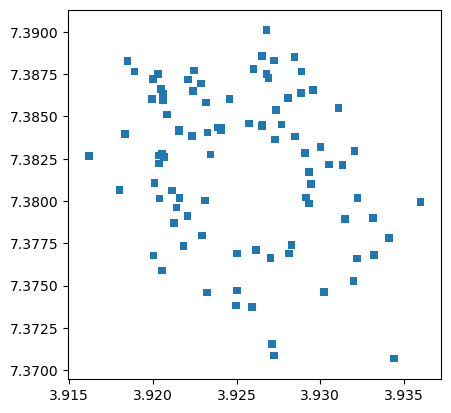

In [132]:
shp_agugu.plot()

In [134]:
shp_agugu.to_dict()

{'city': {0: 'Ibadan'},
 'ward': {0: 'Agugu'},
 'ea_code': {0: 'Ag_001'},
 'EAS': {0: 'Opposite Christ the king primary school I'},
 'Settleme': {0: 'slum'},
 'stroke': {0: '#232323'},
 'stroke-w': {0: 2.0},
 'stroke-o': {0: 1.0},
 'fill': {0: '#FF3333'},
 'fill-opa': {0: 0.0},
 'Longitud': {0: 3.919976},
 'Latitude': {0: 7.386031},
 'geometry': {0: <MULTIPOLYGON (((3.92 7.386, 3.92 7.386, 3.92 7.386, 3.92 7.386, 3.92 7.386)...>}}

In [135]:
dict_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_001",
        "EAS": "Opposite Christ the king primary school I",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.919976,
        "Latitude": 7.386031
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.919749543188542,
              7.385804907066761
            ],
            [
              3.920202456811458,
              7.385804907066761
            ],
            [
              3.920202456811458,
              7.386257092933239
            ],
            [
              3.919749543188542,
              7.386257092933239
            ],
            [
              3.919749543188542,
              7.385804907066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_002",
        "EAS": "Beside Christ the King Primary School I",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.920514,
        "Latitude": 7.386621
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.920287542886243,
              7.3863949070667605
            ],
            [
              3.9207404571137565,
              7.3863949070667605
            ],
            [
              3.9207404571137565,
              7.386847092933239
            ],
            [
              3.920287542886243,
              7.386847092933239
            ],
            [
              3.920287542886243,
              7.3863949070667605
            ]
          ]
        ]
      },
      "id": 1
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_003",
        "EAS": "Behind Christ the kind Primary School I",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.920633558,
        "Latitude": 7.385971842
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9204071012188515,
              7.385745749066761
            ],
            [
              3.9208600147811485,
              7.385745749066761
            ],
            [
              3.9208600147811485,
              7.386197934933239
            ],
            [
              3.9204071012188515,
              7.386197934933239
            ],
            [
              3.9204071012188515,
              7.385745749066761
            ]
          ]
        ]
      },
      "id": 2
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_004",
        "EAS": "Behind The Board of Trade",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.922893536,
        "Latitude": 7.386946779
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9226670787193134,
              7.38672068606676
            ],
            [
              3.923119993280687,
              7.38672068606676
            ],
            [
              3.923119993280687,
              7.387172871933239
            ],
            [
              3.9226670787193134,
              7.387172871933239
            ],
            [
              3.9226670787193134,
              7.38672068606676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_005",
        "EAS": "Opposite The Board of Trade",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.922421448,
        "Latitude": 7.386521237
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.922194990937361,
              7.386295144066761
            ],
            [
              3.9226479050626395,
              7.386295144066761
            ],
            [
              3.9226479050626395,
              7.38674732993324
            ],
            [
              3.922194990937361,
              7.38674732993324
            ],
            [
              3.922194990937361,
              7.386295144066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_006",
        "EAS": "Adjacent The Board of Trade",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.923172466,
        "Latitude": 7.38581369
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.922946009299879,
              7.385587597066761
            ],
            [
              3.923398922700121,
              7.385587597066761
            ],
            [
              3.923398922700121,
              7.386039782933239
            ],
            [
              3.922946009299879,
              7.386039782933239
            ],
            [
              3.922946009299879,
              7.385587597066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_008",
        "EAS": "Oladebo shopping complex",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.921571964,
        "Latitude": 7.384155616
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9213455081492685,
              7.383929523066761
            ],
            [
              3.9217984198507314,
              7.383929523066761
            ],
            [
              3.9217984198507314,
              7.3843817089332395
            ],
            [
              3.9213455081492685,
              7.3843817089332395
            ],
            [
              3.9213455081492685,
              7.383929523066761
            ]
          ]
        ]
      },
      "id": 6
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_009",
        "EAS": "Agugu Central Hospital",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.920848477,
        "Latitude": 7.385116937
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9206220206568316,
              7.384890844066761
            ],
            [
              3.921074933343168,
              7.384890844066761
            ],
            [
              3.921074933343168,
              7.38534302993324
            ],
            [
              3.9206220206568316,
              7.38534302993324
            ],
            [
              3.9206220206568316,
              7.384890844066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_011",
        "EAS": "St Mary Health Post",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.918359019,
        "Latitude": 7.383961575
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.918132563248658,
              7.3837354820667604
            ],
            [
              3.918585474751342,
              7.3837354820667604
            ],
            [
              3.918585474751342,
              7.384187667933239
            ],
            [
              3.918132563248658,
              7.384187667933239
            ],
            [
              3.918132563248658,
              7.3837354820667604
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_012",
        "EAS": "Bello Store",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.9162159,
        "Latitude": 7.382668716
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9159894449108035,
              7.382442623066761
            ],
            [
              3.9164423550891967,
              7.382442623066761
            ],
            [
              3.9164423550891967,
              7.38289480893324
            ],
            [
              3.9159894449108035,
              7.38289480893324
            ],
            [
              3.9159894449108035,
              7.382442623066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_013",
        "EAS": "vicky communication",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.920563774,
        "Latitude": 7.38280837
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9203373188392847,
              7.382582277066761
            ],
            [
              3.9207902291607155,
              7.382582277066761
            ],
            [
              3.9207902291607155,
              7.38303446293324
            ],
            [
              3.9203373188392847,
              7.38303446293324
            ],
            [
              3.9203373188392847,
              7.382582277066761
            ]
          ]
        ]
      },
      "id": 10
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_015",
        "EAS": "Agugu Police Station",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.920365227,
        "Latitude": 7.382207356
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.920138772147063,
              7.381981263066761
            ],
            [
              3.920591681852937,
              7.381981263066761
            ],
            [
              3.920591681852937,
              7.38243344893324
            ],
            [
              3.920138772147063,
              7.38243344893324
            ],
            [
              3.920138772147063,
              7.381981263066761
            ]
          ]
        ]
      },
      "id": 11
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_018",
        "EAS": "Dotpay-Hammed Olanrewaju",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.921159095,
        "Latitude": 7.380613884
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9209326409629526,
              7.38038779106676
            ],
            [
              3.9213855490370477,
              7.38038779106676
            ],
            [
              3.9213855490370477,
              7.380839976933239
            ],
            [
              3.9209326409629526,
              7.380839976933239
            ],
            [
              3.9209326409629526,
              7.38038779106676
            ]
          ]
        ]
      },
      "id": 12
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_019",
        "EAS": "Aremo District",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.920107735,
        "Latitude": 7.381079525
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.919881280724554,
              7.38085343206676
            ],
            [
              3.9203341892754464,
              7.38085343206676
            ],
            [
              3.9203341892754464,
              7.381305617933239
            ],
            [
              3.919881280724554,
              7.381305617933239
            ],
            [
              3.919881280724554,
              7.38085343206676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_020",
        "EAS": "Islamic mission primary school 3",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.922351351,
        "Latitude": 7.383852706
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9221248953044205,
              7.3836266130667605
            ],
            [
              3.9225778066955796,
              7.3836266130667605
            ],
            [
              3.9225778066955796,
              7.384078798933239
            ],
            [
              3.9221248953044205,
              7.384078798933239
            ],
            [
              3.9221248953044205,
              7.3836266130667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_021",
        "EAS": "W D Motel",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.923274075,
        "Latitude": 7.384057519
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.923047619199515,
              7.38383142606676
            ],
            [
              3.923500530800485,
              7.38383142606676
            ],
            [
              3.923500530800485,
              7.384283611933239
            ],
            [
              3.923047619199515,
              7.384283611933239
            ],
            [
              3.923047619199515,
              7.38383142606676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_024",
        "EAS": "Idi Obi Agugu Road",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.92345654,
        "Latitude": 7.382751606
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9232300848683543,
              7.382525513066761
            ],
            [
              3.923682995131646,
              7.382525513066761
            ],
            [
              3.923682995131646,
              7.38297769893324
            ],
            [
              3.9232300848683543,
              7.38297769893324
            ],
            [
              3.9232300848683543,
              7.382525513066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_027",
        "EAS": "Behind Biship Oyebode Anglican Church",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.929441683,
        "Latitude": 7.381020966
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9292152287545354,
              7.380794873066761
            ],
            [
              3.9296681372454643,
              7.380794873066761
            ],
            [
              3.9296681372454643,
              7.38124705893324
            ],
            [
              3.9292152287545354,
              7.38124705893324
            ],
            [
              3.9292152287545354,
              7.380794873066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_028",
        "EAS": "mufutau olanihun com high sch 4",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.931311215,
        "Latitude": 7.382127879
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.931084760187761,
              7.38190178606676
            ],
            [
              3.931537669812239,
              7.38190178606676
            ],
            [
              3.931537669812239,
              7.382353971933239
            ],
            [
              3.931084760187761,
              7.382353971933239
            ],
            [
              3.931084760187761,
              7.38190178606676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_030",
        "EAS": "Talim Central Mosque",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.928143417,
        "Latitude": 7.376893871
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9279169648669687,
              7.376667778066761
            ],
            [
              3.928369869133031,
              7.376667778066761
            ],
            [
              3.928369869133031,
              7.377119963933239
            ],
            [
              3.9279169648669687,
              7.377119963933239
            ],
            [
              3.9279169648669687,
              7.376667778066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_033",
        "EAS": "Community Secondary School, Ayekale",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.928291145,
        "Latitude": 7.377393246
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9280646926114313,
              7.37716715306676
            ],
            [
              3.928517597388569,
              7.37716715306676
            ],
            [
              3.928517597388569,
              7.377619338933239
            ],
            [
              3.9280646926114313,
              7.377619338933239
            ],
            [
              3.9280646926114313,
              7.37716715306676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_035",
        "EAS": "Koloko Idi-obi road",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.927018702,
        "Latitude": 7.376615436
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.926792250009441,
              7.37638934306676
            ],
            [
              3.9272451539905586,
              7.37638934306676
            ],
            [
              3.9272451539905586,
              7.376841528933239
            ],
            [
              3.926792250009441,
              7.376841528933239
            ],
            [
              3.926792250009441,
              7.37638934306676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_036",
        "EAS": "Ayekale Community Hospital",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.9261722,
        "Latitude": 7.377082026
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9259457477706894,
              7.376855933066761
            ],
            [
              3.9263986522293104,
              7.376855933066761
            ],
            [
              3.9263986522293104,
              7.3773081189332395
            ],
            [
              3.9259457477706894,
              7.3773081189332395
            ],
            [
              3.9259457477706894,
              7.376855933066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_037",
        "EAS": "Mope Road, Behind Reflections College",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.925028503,
        "Latitude": 7.376892077
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9248020508678874,
              7.3766659840667606
            ],
            [
              3.9252549551321128,
              7.3766659840667606
            ],
            [
              3.9252549551321128,
              7.377118169933239
            ],
            [
              3.9248020508678874,
              7.377118169933239
            ],
            [
              3.9248020508678874,
              7.3766659840667606
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_041",
        "EAS": "Opposite United Secondary School3",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.922939041,
        "Latitude": 7.377956079
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.922712588323399,
              7.37772998606676
            ],
            [
              3.9231654936766005,
              7.37772998606676
            ],
            [
              3.9231654936766005,
              7.378182171933239
            ],
            [
              3.922712588323399,
              7.378182171933239
            ],
            [
              3.922712588323399,
              7.37772998606676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_042",
        "EAS": "Ajibola Junction",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.91801178,
        "Latitude": 7.380639477
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9177853259498496,
              7.3804133840667605
            ],
            [
              3.9182382340501505,
              7.3804133840667605
            ],
            [
              3.9182382340501505,
              7.380865569933239
            ],
            [
              3.9177853259498496,
              7.380865569933239
            ],
            [
              3.9177853259498496,
              7.3804133840667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_045",
        "EAS": "Lagelu comm high sch",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.923124229,
        "Latitude": 7.380017042
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.922897775268501,
              7.379790949066761
            ],
            [
              3.923350682731499,
              7.379790949066761
            ],
            [
              3.923350682731499,
              7.38024313493324
            ],
            [
              3.922897775268501,
              7.38024313493324
            ],
            [
              3.922897775268501,
              7.379790949066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_046",
        "EAS": "Ode-Aje Street",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.921600834,
        "Latitude": 7.380163434
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.921374380193559,
              7.379937341066761
            ],
            [
              3.921827287806441,
              7.379937341066761
            ],
            [
              3.921827287806441,
              7.380389526933239
            ],
            [
              3.921374380193559,
              7.380389526933239
            ],
            [
              3.921374380193559,
              7.379937341066761
            ]
          ]
        ]
      },
      "id": 27
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_050",
        "EAS": "Tolaret Global Ventures",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.921840998,
        "Latitude": 7.377324718
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.921614545646499,
              7.37709862506676
            ],
            [
              3.922067450353501,
              7.37709862506676
            ],
            [
              3.922067450353501,
              7.377550810933239
            ],
            [
              3.921614545646499,
              7.377550810933239
            ],
            [
              3.921614545646499,
              7.37709862506676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_051",
        "EAS": "Adekile & Alarere Old Ife Road",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.920542711,
        "Latitude": 7.375880237
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.920316259385607,
              7.37565414406676
            ],
            [
              3.920769162614393,
              7.37565414406676
            ],
            [
              3.920769162614393,
              7.376106329933239
            ],
            [
              3.920316259385607,
              7.376106329933239
            ],
            [
              3.920316259385607,
              7.37565414406676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_052",
        "EAS": "Grace Gospel Apostolic Church International",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.920054549,
        "Latitude": 7.376779321
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.919828096925584,
              7.3765532280667605
            ],
            [
              3.9202810010744162,
              7.3765532280667605
            ],
            [
              3.9202810010744162,
              7.377005413933239
            ],
            [
              3.919828096925584,
              7.377005413933239
            ],
            [
              3.919828096925584,
              7.3765532280667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_053",
        "EAS": "Dotpay-Hamzat Isiaq",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.923227587,
        "Latitude": 7.374587431
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.92300113604698,
              7.374361338066761
            ],
            [
              3.92345403795302,
              7.374361338066761
            ],
            [
              3.92345403795302,
              7.3748135239332395
            ],
            [
              3.92300113604698,
              7.3748135239332395
            ],
            [
              3.92300113604698,
              7.374361338066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_059",
        "EAS": "Agugu High School",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.928482473,
        "Latitude": 7.383816567
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9282560173229304,
              7.383590474066761
            ],
            [
              3.9287089286770693,
              7.383590474066761
            ],
            [
              3.9287089286770693,
              7.38404265993324
            ],
            [
              3.9282560173229304,
              7.38404265993324
            ],
            [
              3.9282560173229304,
              7.383590474066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_063",
        "EAS": "Bishop Oyebode Memorial Anglican Church",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.9305083,
        "Latitude": 7.382162427
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.93028184517007,
              7.3819363340667605
            ],
            [
              3.9307347548299303,
              7.3819363340667605
            ],
            [
              3.9307347548299303,
              7.382388519933239
            ],
            [
              3.93028184517007,
              7.382388519933239
            ],
            [
              3.93028184517007,
              7.3819363340667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_065",
        "EAS": "Coldcubes Pharmacy",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.930014773,
        "Latitude": 7.383173217
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9297883176524344,
              7.382947124066761
            ],
            [
              3.9302412283475654,
              7.382947124066761
            ],
            [
              3.9302412283475654,
              7.38339930993324
            ],
            [
              3.9297883176524344,
              7.38339930993324
            ],
            [
              3.9297883176524344,
              7.382947124066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_066",
        "EAS": "The Baptist Chapel",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.928879993,
        "Latitude": 7.387664417
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9286535353515664,
              7.3874383240667605
            ],
            [
              3.9291064506484332,
              7.3874383240667605
            ],
            [
              3.9291064506484332,
              7.387890509933239
            ],
            [
              3.9286535353515664,
              7.387890509933239
            ],
            [
              3.9286535353515664,
              7.3874383240667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_067",
        "EAS": "Marcedonia Hospital",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.92845084,
        "Latitude": 7.388504959
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.928224381920792,
              7.38827886606676
            ],
            [
              3.928677298079208,
              7.38827886606676
            ],
            [
              3.928677298079208,
              7.388731051933239
            ],
            [
              3.928224381920792,
              7.388731051933239
            ],
            [
              3.928224381920792,
              7.38827886606676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_068",
        "EAS": "Bishop Finn Memorial Nursery and Primary School",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.926782407,
        "Latitude": 7.390092866
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.926555948106859,
              7.38986677306676
            ],
            [
              3.9270088658931415,
              7.38986677306676
            ],
            [
              3.9270088658931415,
              7.390318958933239
            ],
            [
              3.926555948106859,
              7.390318958933239
            ],
            [
              3.926555948106859,
              7.38986677306676
            ]
          ]
        ]
      },
      "id": 37
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_069",
        "EAS": "Christ Anointed Koloko",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.925039723,
        "Latitude": 7.374696661
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.924813271991105,
              7.37447056806676
            ],
            [
              3.9252661740088945,
              7.37447056806676
            ],
            [
              3.9252661740088945,
              7.374922753933239
            ],
            [
              3.924813271991105,
              7.374922753933239
            ],
            [
              3.924813271991105,
              7.37447056806676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_070",
        "EAS": "Ade Rentals",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.925919488,
        "Latitude": 7.373739052
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.925693037480929,
              7.373512959066761
            ],
            [
              3.926145938519071,
              7.373512959066761
            ],
            [
              3.926145938519071,
              7.37396514493324
            ],
            [
              3.925693037480929,
              7.37396514493324
            ],
            [
              3.925693037480929,
              7.373512959066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_071",
        "EAS": "Kedi Office, Ibadan",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.924969986,
        "Latitude": 7.373818853
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9247435354401126,
              7.373592760066761
            ],
            [
              3.925196436559887,
              7.373592760066761
            ],
            [
              3.925196436559887,
              7.37404494593324
            ],
            [
              3.9247435354401126,
              7.37404494593324
            ],
            [
              3.9247435354401126,
              7.373592760066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_073",
        "EAS": "Green Spring Close",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.927679265,
        "Latitude": 7.384518376
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9274528089634524,
              7.3842922830667606
            ],
            [
              3.927905721036548,
              7.3842922830667606
            ],
            [
              3.927905721036548,
              7.384744468933239
            ],
            [
              3.9274528089634524,
              7.384744468933239
            ],
            [
              3.9274528089634524,
              7.3842922830667606
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_074",
        "EAS": "Abu Ammar Concepts",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.928073524,
        "Latitude": 7.386092917
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9278470671568186,
              7.385866824066761
            ],
            [
              3.9282999808431818,
              7.385866824066761
            ],
            [
              3.9282999808431818,
              7.386319009933239
            ],
            [
              3.9278470671568186,
              7.386319009933239
            ],
            [
              3.9278470671568186,
              7.385866824066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_075",
        "EAS": "Agugu High School",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.927289539,
        "Latitude": 7.383639565
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.927063083413589,
              7.383413472066761
            ],
            [
              3.9275159945864115,
              7.383413472066761
            ],
            [
              3.9275159945864115,
              7.38386565793324
            ],
            [
              3.927063083413589,
              7.38386565793324
            ],
            [
              3.927063083413589,
              7.383413472066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_076",
        "EAS": "Vicky Communications",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.929081255,
        "Latitude": 7.382836254
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9288547998250043,
              7.3826101610667605
            ],
            [
              3.9293077101749954,
              7.3826101610667605
            ],
            [
              3.9293077101749954,
              7.383062346933239
            ],
            [
              3.9288547998250043,
              7.383062346933239
            ],
            [
              3.9288547998250043,
              7.3826101610667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_078",
        "EAS": "Okebadan Junior High School",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.926004438,
        "Latitude": 7.387817477
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9257779802731276,
              7.38759138406676
            ],
            [
              3.9262308957268726,
              7.38759138406676
            ],
            [
              3.9262308957268726,
              7.388043569933239
            ],
            [
              3.9257779802731276,
              7.388043569933239
            ],
            [
              3.9257779802731276,
              7.38759138406676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_079",
        "EAS": "Anglican Church",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.926530148,
        "Latitude": 7.388591514
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.92630368987643,
              7.38836542106676
            ],
            [
              3.9267566061235697,
              7.38836542106676
            ],
            [
              3.9267566061235697,
              7.388817606933239
            ],
            [
              3.92630368987643,
              7.388817606933239
            ],
            [
              3.92630368987643,
              7.38836542106676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_080",
        "EAS": "EDUICARE Comprehensive",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.927238251,
        "Latitude": 7.38830956
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9270117930209376,
              7.38808346706676
            ],
            [
              3.927464708979062,
              7.38808346706676
            ],
            [
              3.927464708979062,
              7.388535652933239
            ],
            [
              3.9270117930209376,
              7.388535652933239
            ],
            [
              3.9270117930209376,
              7.38808346706676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_081",
        "EAS": "Olorode Street",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.931080433,
        "Latitude": 7.385488381
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9308539764665418,
              7.385262288066761
            ],
            [
              3.931306889533458,
              7.385262288066761
            ],
            [
              3.931306889533458,
              7.385714473933239
            ],
            [
              3.9308539764665418,
              7.385714473933239
            ],
            [
              3.9308539764665418,
              7.385262288066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_083",
        "EAS": "Irewumi Street",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.928845483,
        "Latitude": 7.386389327
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9286190260049487,
              7.3861632340667605
            ],
            [
              3.929071939995051,
              7.3861632340667605
            ],
            [
              3.929071939995051,
              7.386615419933239
            ],
            [
              3.9286190260049487,
              7.386615419933239
            ],
            [
              3.9286190260049487,
              7.3861632340667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_086",
        "EAS": "Help line school",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.918918523,
        "Latitude": 7.387662584
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9186920653525057,
              7.387436491066761
            ],
            [
              3.919144980647494,
              7.387436491066761
            ],
            [
              3.919144980647494,
              7.3878886769332395
            ],
            [
              3.9186920653525057,
              7.3878886769332395
            ],
            [
              3.9186920653525057,
              7.387436491066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_087",
        "EAS": "St Mary Catholic Hospital",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.920305278,
        "Latitude": 7.38750312
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9200788204342247,
              7.3872770270667605
            ],
            [
              3.920531735565775,
              7.3872770270667605
            ],
            [
              3.920531735565775,
              7.387729212933239
            ],
            [
              3.9200788204342247,
              7.387729212933239
            ],
            [
              3.9200788204342247,
              7.3872770270667605
            ]
          ]
        ]
      },
      "id": 54
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_088",
        "EAS": "Tee Show Graphic Designer",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.918505463,
        "Latitude": 7.38826905
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9182790050416996,
              7.3880429570667605
            ],
            [
              3.9187319209583,
              7.3880429570667605
            ],
            [
              3.9187319209583,
              7.388495142933239
            ],
            [
              3.9182790050416996,
              7.388495142933239
            ],
            [
              3.9182790050416996,
              7.3880429570667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_089",
        "EAS": "Foursquare Gospel Church Berachah Assembly",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.922109595,
        "Latitude": 7.387178841
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.921883137600399,
              7.3869527480667605
            ],
            [
              3.9223360523996007,
              7.3869527480667605
            ],
            [
              3.9223360523996007,
              7.387404933933239
            ],
            [
              3.921883137600399,
              7.387404933933239
            ],
            [
              3.921883137600399,
              7.3869527480667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_090",
        "EAS": "Ratibi Muslim pry sch 1",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.92247974,
        "Latitude": 7.38770551
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9222532823305074,
              7.387479417066761
            ],
            [
              3.9227061976694926,
              7.387479417066761
            ],
            [
              3.9227061976694926,
              7.387931602933239
            ],
            [
              3.9222532823305074,
              7.387931602933239
            ],
            [
              3.9222532823305074,
              7.387479417066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_093",
        "EAS": "Temitayo Cool Sport",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.92407797,
        "Latitude": 7.384333199
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9238515140583066,
              7.384107106066761
            ],
            [
              3.9243044259416933,
              7.384107106066761
            ],
            [
              3.9243044259416933,
              7.38455929193324
            ],
            [
              3.9238515140583066,
              7.38455929193324
            ],
            [
              3.9238515140583066,
              7.384107106066761
            ]
          ]
        ]
      },
      "id": 60
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_095",
        "EAS": "Agoro Basorun Investment Ltd",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.925733248,
        "Latitude": 7.384587318
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9255067919281372,
              7.384361225066761
            ],
            [
              3.9259597040718623,
              7.384361225066761
            ],
            [
              3.9259597040718623,
              7.38481341093324
            ],
            [
              3.9255067919281372,
              7.38481341093324
            ],
            [
              3.9255067919281372,
              7.384361225066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_096",
        "EAS": "Georgina Ogunmola",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.926789987,
        "Latitude": 7.387510481
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.926563529430452,
              7.38728438806676
            ],
            [
              3.9270164445695475,
              7.38728438806676
            ],
            [
              3.9270164445695475,
              7.387736573933239
            ],
            [
              3.926563529430452,
              7.387736573933239
            ],
            [
              3.926563529430452,
              7.38728438806676
            ]
          ]
        ]
      },
      "id": 58
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_097",
        "EAS": "Renascent Jnr School 1",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.921426657,
        "Latitude": 7.379614422
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9212002034746045,
              7.379388329066761
            ],
            [
              3.9216531105253956,
              7.379388329066761
            ],
            [
              3.9216531105253956,
              7.37984051493324
            ],
            [
              3.9212002034746045,
              7.37984051493324
            ],
            [
              3.9212002034746045,
              7.379388329066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_099",
        "EAS": "Renascent Jnr School 3",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.922075752,
        "Latitude": 7.379122323
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9218492987264977,
              7.37889623006676
            ],
            [
              3.9223022052735024,
              7.37889623006676
            ],
            [
              3.9223022052735024,
              7.379348415933239
            ],
            [
              3.9218492987264977,
              7.379348415933239
            ],
            [
              3.9218492987264977,
              7.37889623006676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_100",
        "EAS": "Renascent High School",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.921266466,
        "Latitude": 7.378691421
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.921040012947051,
              7.378465328066761
            ],
            [
              3.921492919052949,
              7.378465328066761
            ],
            [
              3.921492919052949,
              7.3789175139332395
            ],
            [
              3.921040012947051,
              7.3789175139332395
            ],
            [
              3.921040012947051,
              7.378465328066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_101",
        "EAS": "Church of Christ Kokolo Olopometa",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.927122466,
        "Latitude": 7.371527643
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.926896016611831,
              7.371301550066761
            ],
            [
              3.927348915388169,
              7.371301550066761
            ],
            [
              3.927348915388169,
              7.37175373593324
            ],
            [
              3.926896016611831,
              7.37175373593324
            ],
            [
              3.926896016611831,
              7.371301550066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_102",
        "EAS": "Deeper Life Bible Church, Koloko",
        "Settlement": "informal",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#3333FF",
        "fill-opacity": 0,
        "Longitude": 3.927251212,
        "Latitude": 7.370867952
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9270247629491255,
              7.370641859066761
            ],
            [
              3.927477661050874,
              7.370641859066761
            ],
            [
              3.927477661050874,
              7.37109404493324
            ],
            [
              3.9270247629491255,
              7.37109404493324
            ],
            [
              3.9270247629491255,
              7.370641859066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_104",
        "EAS": "Gbedemuke street",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.9359719,
        "Latitude": 7.3799328
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.935745446311626,
              7.37970670706676
            ],
            [
              3.9361983536883742,
              7.37970670706676
            ],
            [
              3.9361983536883742,
              7.380158892933239
            ],
            [
              3.935745446311626,
              7.380158892933239
            ],
            [
              3.935745446311626,
              7.37970670706676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_105",
        "EAS": "Idi oro off gbedemuke",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.9340989,
        "Latitude": 7.3778023
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.933872447402098,
              7.3775762070667605
            ],
            [
              3.934325352597902,
              7.3775762070667605
            ],
            [
              3.934325352597902,
              7.378028392933239
            ],
            [
              3.933872447402098,
              7.378028392933239
            ],
            [
              3.933872447402098,
              7.3775762070667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_106",
        "EAS": "Olorunsogo Street off Akinhinde",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.9343918,
        "Latitude": 7.37067376
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9341653510484087,
              7.3704476670667605
            ],
            [
              3.9346182489515917,
              7.3704476670667605
            ],
            [
              3.9346182489515917,
              7.370899852933239
            ],
            [
              3.9341653510484087,
              7.370899852933239
            ],
            [
              3.9341653510484087,
              7.3704476670667605
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_107",
        "EAS": "Ile Bale, Idi oro",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.9332143,
        "Latitude": 7.3768147
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9329878479074805,
              7.37658860706676
            ],
            [
              3.9334407520925194,
              7.37658860706676
            ],
            [
              3.9334407520925194,
              7.377040792933239
            ],
            [
              3.9329878479074805,
              7.377040792933239
            ],
            [
              3.9329878479074805,
              7.37658860706676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_108",
        "EAS": "RCCG winners parish",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.9321765,
        "Latitude": 7.3765866
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.931950048024196,
              7.376360507066761
            ],
            [
              3.9324029519758046,
              7.376360507066761
            ],
            [
              3.9324029519758046,
              7.37681269293324
            ],
            [
              3.931950048024196,
              7.37681269293324
            ],
            [
              3.931950048024196,
              7.376360507066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_109",
        "EAS": "Bethel kiddies idi oro",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.9319716,
        "Latitude": 7.3752487
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9317451487087034,
              7.375022607066761
            ],
            [
              3.932198051291296,
              7.375022607066761
            ],
            [
              3.932198051291296,
              7.37547479293324
            ],
            [
              3.9317451487087034,
              7.37547479293324
            ],
            [
              3.9317451487087034,
              7.375022607066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_110",
        "EAS": "Mobolaji hospital along Dalemo street",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.93222,
        "Latitude": 7.38017
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.931993546190198,
              7.37994390706676
            ],
            [
              3.9324464538098023,
              7.37994390706676
            ],
            [
              3.9324464538098023,
              7.380396092933239
            ],
            [
              3.931993546190198,
              7.380396092933239
            ],
            [
              3.931993546190198,
              7.37994390706676
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_111",
        "EAS": "Dalemo street (parallel to the express road)",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.93147,
        "Latitude": 7.37893
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.931243546824938,
              7.378703907066761
            ],
            [
              3.931696453175062,
              7.378703907066761
            ],
            [
              3.931696453175062,
              7.37915609293324
            ],
            [
              3.931243546824938,
              7.37915609293324
            ],
            [
              3.931243546824938,
              7.378703907066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_112",
        "EAS": "Christ the great physician (along Dalemo street)",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.93023,
        "Latitude": 7.3746
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.930003549040551,
              7.374373907066761
            ],
            [
              3.930456450959449,
              7.374373907066761
            ],
            [
              3.930456450959449,
              7.374826092933239
            ],
            [
              3.930003549040551,
              7.374826092933239
            ],
            [
              3.930003549040551,
              7.374373907066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_113",
        "EAS": "Alhaji Tawa street (off Dalemo)",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.9331467,
        "Latitude": 7.3789974
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.93292024679044,
              7.378771307066761
            ],
            [
              3.93337315320956,
              7.378771307066761
            ],
            [
              3.93337315320956,
              7.37922349293324
            ],
            [
              3.93292024679044,
              7.37922349293324
            ],
            [
              3.93292024679044,
              7.378771307066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_029",
        "EAS": "Adjacent Heart 2 Heart Hotel",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.929315749,
        "Latitude": 7.379848424
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.929089295354819,
              7.379622331066761
            ],
            [
              3.929542202645181,
              7.379622331066761
            ],
            [
              3.929542202645181,
              7.38007451693324
            ],
            [
              3.929089295354819,
              7.38007451693324
            ],
            [
              3.929089295354819,
              7.379622331066761
            ]
          ]
        ]
      },
      "id": 74
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_047",
        "EAS": "Concord Palace Hotel",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.920415298,
        "Latitude": 7.380147474
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9201888442017294,
              7.379921381066761
            ],
            [
              3.9206417517982706,
              7.379921381066761
            ],
            [
              3.9206417517982706,
              7.3803735669332395
            ],
            [
              3.9201888442017294,
              7.3803735669332395
            ],
            [
              3.9201888442017294,
              7.379921381066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_058",
        "EAS": "Living Faith Church",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.926551283,
        "Latitude": 7.384529437
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9263248269577864,
              7.384303344066761
            ],
            [
              3.926777739042213,
              7.384303344066761
            ],
            [
              3.926777739042213,
              7.38475552993324
            ],
            [
              3.9263248269577864,
              7.38475552993324
            ],
            [
              3.9263248269577864,
              7.384303344066761
            ]
          ]
        ]
      },
      "id": 83
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_060",
        "EAS": "Kunle Rinto Organization",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.927355945,
        "Latitude": 7.385369984
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9271294885271977,
              7.385143891066761
            ],
            [
              3.9275824014728022,
              7.385143891066761
            ],
            [
              3.9275824014728022,
              7.38559607693324
            ],
            [
              3.9271294885271977,
              7.38559607693324
            ],
            [
              3.9271294885271977,
              7.385143891066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_061",
        "EAS": "Lemarh Creative Empire",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.929555274,
        "Latitude": 7.386566888
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9293288169139697,
              7.386340795066761
            ],
            [
              3.9297817310860306,
              7.386340795066761
            ],
            [
              3.9297817310860306,
              7.386792980933239
            ],
            [
              3.9293288169139697,
              7.386792980933239
            ],
            [
              3.9293288169139697,
              7.386340795066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_064",
        "EAS": "Simply Ayinke fashion hub",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.929328094,
        "Latitude": 7.381710089
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.929101639401693,
              7.381483996066761
            ],
            [
              3.929554548598307,
              7.381483996066761
            ],
            [
              3.929554548598307,
              7.38193618193324
            ],
            [
              3.929101639401693,
              7.38193618193324
            ],
            [
              3.929101639401693,
              7.381483996066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_082",
        "EAS": "Labake Trading Stores",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.93202719,
        "Latitude": 7.382947972
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9318007347677906,
              7.382721879066761
            ],
            [
              3.932253645232209,
              7.382721879066761
            ],
            [
              3.932253645232209,
              7.38317406493324
            ],
            [
              3.9318007347677906,
              7.38317406493324
            ],
            [
              3.9318007347677906,
              7.382721879066761
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "city": "Ibadan",
        "ward": "Agugu",
        "ea_code": "Ag_094",
        "EAS": "Christ Apostolic Church",
        "Settlement": "slum",
        "stroke": "#232323",
        "stroke-width": 2,
        "stroke-opacity": 1,
        "fill": "#FF3333",
        "fill-opacity": 0,
        "Longitude": 3.924574178,
        "Latitude": 7.386018261
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9243477211950686,
              7.385792168066761
            ],
            [
              3.924800634804931,
              7.385792168066761
            ],
            [
              3.924800634804931,
              7.38624435393324
            ],
            [
              3.9243477211950686,
              7.38624435393324
            ],
            [
              3.9243477211950686,
              7.385792168066761
            ]
          ]
        ]
      }
    }
  ]
}

In [139]:
proc_agu = dict_json["features"]
len(proc_agu)

81

In [143]:
dd = proc_agu[0]
dd

{'type': 'Feature',
 'properties': {'city': 'Ibadan',
  'ward': 'Agugu',
  'ea_code': 'Ag_001',
  'EAS': 'Opposite Christ the king primary school I',
  'Settlement': 'slum',
  'stroke': '#232323',
  'stroke-width': 2,
  'stroke-opacity': 1,
  'fill': '#FF3333',
  'fill-opacity': 0,
  'Longitude': 3.919976,
  'Latitude': 7.386031},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[3.919749543188542, 7.385804907066761],
    [3.920202456811458, 7.385804907066761],
    [3.920202456811458, 7.386257092933239],
    [3.919749543188542, 7.386257092933239],
    [3.919749543188542, 7.385804907066761]]]}}

In [146]:
dd["properties"]["ea_code"]

'Ag_001'

In [148]:
for item_dict in proc_agu:
    djs = {"type": "FeatureCollection",
           "features": [item_dict]}
    file_id = item_dict["properties"]["ea_code"]

    ### Save JSON to a file
    data_dir = "../data-out/shapefiles/Agugu/"
    file_dir = data_dir + file_id + "/"
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    with open(f"{file_dir}{file_id}_c20m.json", 'w') as f:
        json.dump(djs, f)

In [ ]:
    ### Save JSON to a file
    with open('../data-out/shapefiles/Agugu/  /ibadan_json_file_c20m_v1.json', 'w') as f:
        json.dump(json_data, f)